# Time Series Forecast with Prophet

In [174]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import itertools
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

### Lectura y Exploración del dataset

In [176]:
df = pd.read_csv("Aquifer.csv")

# Drop nulls
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Drop useless columns
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']

# transform date column into datetime
from datetime import datetime, date 
df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')
df.head()

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
3,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
4,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3


### Serie temporal

Solo usaremos la variable a predecir, depth to groundwater y el resto no, por restricciones del problema no podemos disponer de ningun tipo de informacion a futuro

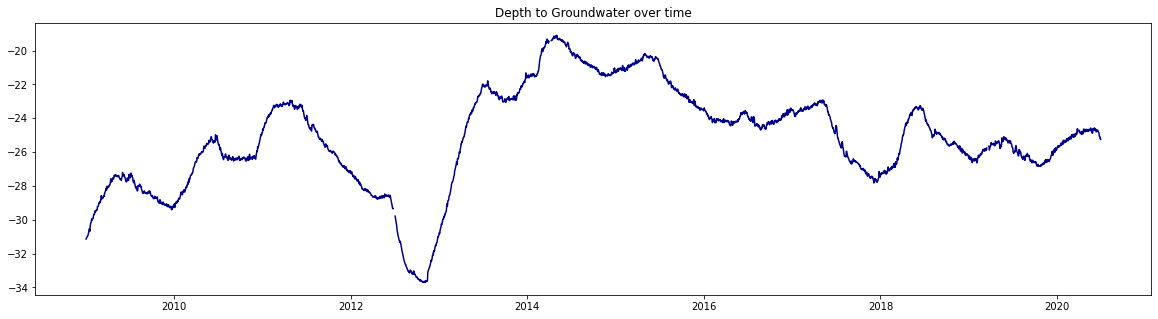

In [177]:
plt.figure(figsize=(20, 5))
plt.plot(df.Date, df.Depth_to_Groundwater.fillna(np.inf), color='darkblue')
plt.title("Depth to Groundwater over time")
plt.show()

# Note:
The target is not seasonal for our forecasting

### Procesamiento de los datos

#### Orden cronológico
Comprobamos si la serie está en orden cronológico y si los puntos equidistan entre si

In [180]:
# Sort values by timestamp (not necessary in this case)
df = df.sort_values(by='Date')

# Check time intervals
df['Interval'] = df.Date - df.Date.shift(1)
df[['Date', 'Interval']].sort_values("Interval", ascending=False).head()

,Date,Interval
1,2009-01-02,1 days
2789,2016-08-21,1 days
2791,2016-08-23,1 days
2792,2016-08-24,1 days
2793,2016-08-25,1 days


In [133]:
df = df.drop('Interval', axis=1)

#### Nulls

In [134]:
print(df.isnull().sum())

Date                     0
Rainfall                 0
Depth_to_Groundwater    27
Temperature              0
Drainage_Volume          1
River_Hydrometry         0
dtype: int64


Hay valores nulos en la variable a predecir Depth_to_Groundwater.
Hay diferentes opciones para reemplazarlos, rellenar con ceros, interpolar, rellenar con la media, o con el último valor.
Para comprobar cual es el mejor método sacamos los gráficos:

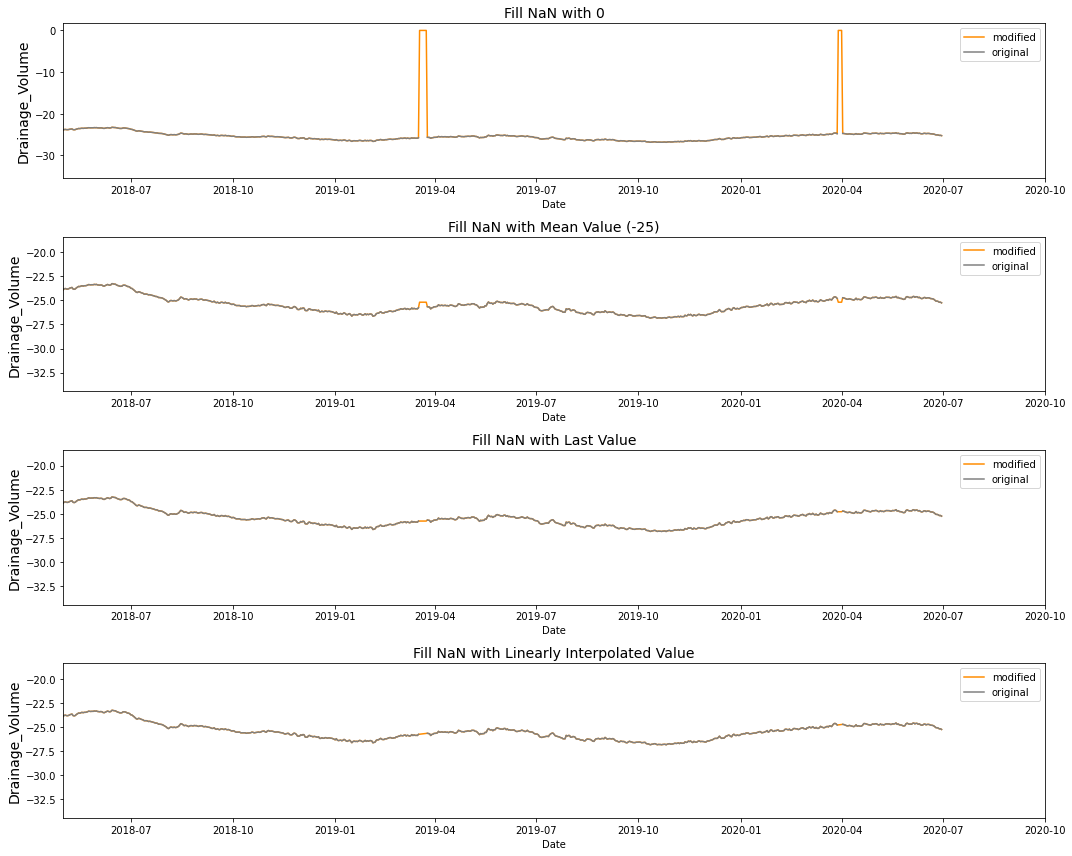

In [135]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

#option1
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.fillna(np.inf), ax=ax[0], color='grey', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage_Volume', fontsize=14)

#option2
mean_val = df.Depth_to_Groundwater.mean()
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.fillna(mean_val), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.fillna(np.inf), ax=ax[1], color='grey', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_val:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Drainage_Volume', fontsize=14)

#option3
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.fillna(np.inf), ax=ax[2], color='grey', label = 'original')
ax[2].set_title(f'Fill NaN with Last Value', fontsize=14)
ax[2].set_ylabel(ylabel='Drainage_Volume', fontsize=14)

#option4
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.fillna(np.inf), ax=ax[3], color='grey', label = 'original')
ax[3].set_title(f'Fill NaN with Linearly Interpolated Value', fontsize=14)
ax[3].set_ylabel(ylabel='Drainage_Volume', fontsize=14)


for i in range(4):
    ax[i].set_xlim([date(2018, 5, 1), date(2020, 10, 1)])
plt.tight_layout()
plt.show()

plt.show()

Examinando los graficos, vemos que la opcion de rellenar los valores nulos con valores interpolados es la que mejor se adapta a la distribucion de este ejemplo. Para ello necesitamos los valores de los puntos vecinos, que para nuestro caso no hay problema.


In [136]:
df['Depth_to_Groundwater'] = df['Depth_to_Groundwater'].interpolate()

### Creación de variables

Creamos variables temporales, ya que son las unicas que vamos a poder predecir con seguridad y pueden ayudar al modelo

In [137]:
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day'] = pd.DatetimeIndex(df['Date']).day
df['day_of_year'] = pd.DatetimeIndex(df['Date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['Date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['Date']).quarter
df['season'] = df.month%12 // 3 + 1

df[['Date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """


,Date,year,month,day,day_of_year,week_of_year,quarter,season
0,2009-01-01,2009,1,1,1,1,1,1
1,2009-01-02,2009,1,2,2,1,1,1
2,2009-01-03,2009,1,3,3,1,1,1
3,2009-01-04,2009,1,4,4,1,1,1
4,2009-01-05,2009,1,5,5,2,1,1


Para que no haya un salto entre el mes 12 y el mes 1 o el dia 30 y el dia 1 del siguiente mes, hacemos variables temporales
de tipo seno/coseno:

In [138]:
df['month_sin'] = np.sin(2*np.pi*df.month/12)
df['month_cos'] = np.cos(2*np.pi*df.month/12)

df['day_sin'] = np.sin(2*np.pi*df.day/30)
df['day_cos'] = np.cos(2*np.pi*df.day/30)

days_in_year = 365
df['day_of_year_sin'] = np.sin(2*np.pi*df.day_of_year/365)
df['day_of_year_cos'] = np.cos(2*np.pi*df.day_of_year/365)

weeks_in_year = 52.1429
df['week_of_year_sin'] = np.sin(2*np.pi*df.week_of_year/52.1429)
df['week_of_year_cos'] = np.cos(2*np.pi*df.week_of_year/52.1429)

quarters_in_year = 4
df['quarter_sin'] = np.sin(2*np.pi*df.quarter/4)
df['quarter_cos'] = np.cos(2*np.pi*df.quarter/4)

seasons_in_year = 4
df['season_sin'] = np.sin(2*np.pi*df.season/4)
df['season_cos'] = np.cos(2*np.pi*df.season/4)

No creamos las decomposicion de variables para separar las componentes tendencia, estacional y residuos, ya que el modelo lo hace internamente.

### Prophet


#### Train/Test

Eliminaremos también las variables de temperatura, rainfall, drainage_volume y river_hidrometry ya que en el problema que nos han planteado no podemos utilizar información a futuro, por lo que tendríamos que predecir estas series también, lo que llevaría a un aumento del error agregado.

In [139]:
df["ds"] = df["Date"]
df["y"] = df["Depth_to_Groundwater"]

df = df.drop(["Date", "Depth_to_Groundwater", "Rainfall", "Temperature", "Drainage_Volume", "River_Hydrometry"], axis=1)

train = df[df["ds"]<="2020-02-29"]
test = df[df["ds"]>"2020-02-29"]

print("Train: " + str(len(train)))
print("Test: " + str(len(test)))

Train: 4077
Test: 122


### Grid Search

In [142]:
# Python
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.5],
    'seasonality_prior_scale': [0.01, 10.0],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  

# Cross-validation for time series
for params in all_params:
    m = prophet.Prophet(**params)
    for col in df.drop(["ds", "y"], axis=1).columns[1:]:
        m.add_regressor(col)
    m.fit(train)
    df_cv = cross_validation(m, horizon='100 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 73 forecasts with cutoffs between 2010-01-12 00:00:00 and 2019-11-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000270947C5B70>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 73 forecasts with cutoffs between 2010-01-12 00:00:00 and 2019-11-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000027086225D68>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 73 forecasts with cutoffs between 2010-01-12 00:00:00 and 2019-11-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002708C633C18>
INFO:prophet:Disabling daily seasonality. Run prophet w

   changepoint_prior_scale  seasonality_prior_scale      rmse
0                    0.001                     0.01  3.244440
1                    0.001                    10.00  3.193889
2                    0.500                     0.01  1.647286
3                    0.500                    10.00  1.533563


Tomamos los parámetros de la última iteracion, que son los que presentan menor RMSE. Como es justo el último modelo que hemos entrenado no hace falta reentrenar otro con esos parámetros.

### Metricas


In [156]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,10 days,0.526106,0.725332,0.506200,0.020747,0.013791,0.020673,0.368493
1,11 days,0.552737,0.743463,0.521944,0.021378,0.014465,0.021301,0.371233
2,12 days,0.579664,0.761356,0.538561,0.022045,0.015137,0.021968,0.367123
3,13 days,0.605626,0.778219,0.555650,0.022732,0.015882,0.022656,0.358904
4,14 days,0.627031,0.791853,0.570844,0.023345,0.016240,0.023270,0.349315


Como es lógico el error aumenta según aumenta la ventana de predicción:

<Figure size 1440x360 with 0 Axes>

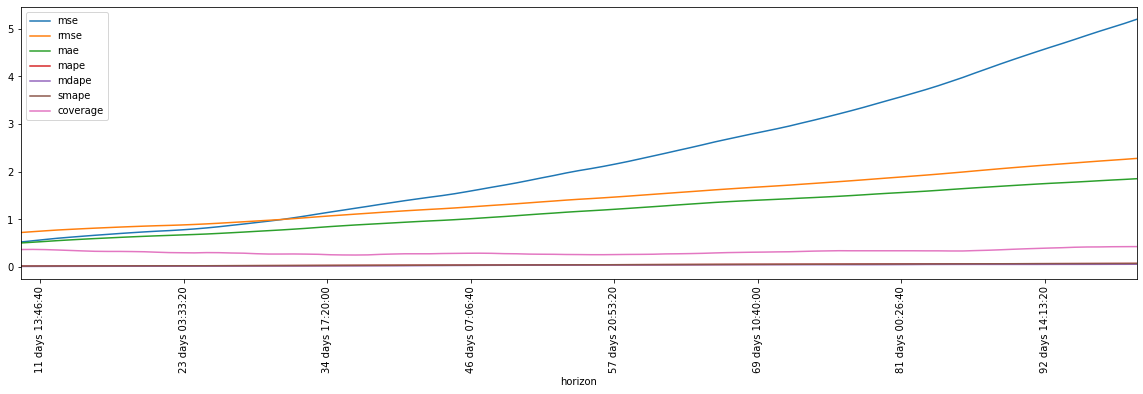

In [158]:
fig = plt.figure(figsize=(20, 5))
df_p.set_index("horizon").plot(figsize=(20, 5), rot=90)

### Forecast

Predicción sobre el test set, a 100 días de distancia:

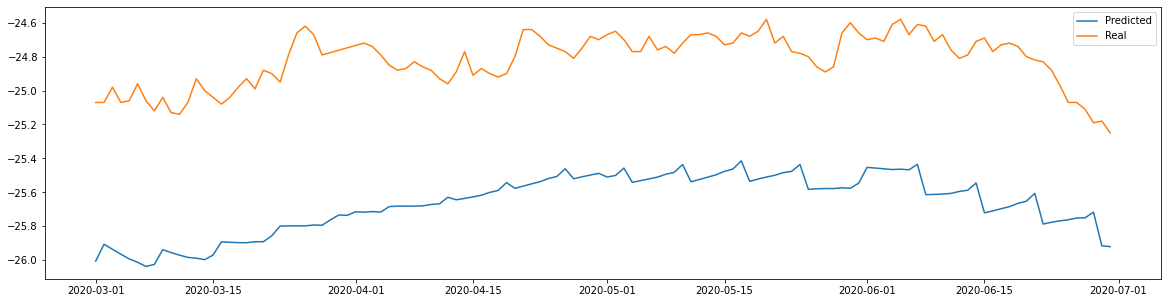

In [182]:
forecast = m.predict(test)

pred = pd.DataFrame()

fig = plt.figure(figsize=(20, 5))
plt.plot(forecast.ds, forecast.yhat)
plt.plot(test.ds, test.y)
plt.legend(["Predicted", "Real"])

Podemos observar que es capaz de capturar la tendencia perfectamente, aunque se queda una unidad por debajo en sus predicciones

##### Error sobre el test:

In [172]:
print("RMSE: ", np.sqrt(mean_squared_error(forecast.yhat, test.y)))

RMSE:  0.8531832654481655
